In [3]:
import json
import os
import numpy as np
from nibabel import load as load_nii
import nibabel as nib
from scipy import ndimage
from scipy.ndimage.morphology import generate_binary_structure as gbs
from scipy.ndimage.measurements import label
import matplotlib.pyplot as plt
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from tqdm import tqdm
import seaborn as sns
%matplotlib inline
import sys
sys.path.append("..")
from config import *
from utils import get_dataframe_from_metadata
import pandas as pd
from tqdm import tqdm

Loading configuration...
Configuration loaded successfully!
_____________________________



In [2]:
df_lesions = get_dataframe_from_metadata()

In [3]:
df_lesions

,dataset,patient,lesion,rim,volume,ignore,main_reason,reasons,location,size
0,0,56,2000,False,146,False,NaN,,WM,"(6, 9, 8)"
1,0,56,2001,False,252,False,NaN,,Periventricular,"(7, 8, 9)"
2,0,56,2002,False,132,False,NaN,,Periventricular,"(6, 6, 6)"
3,0,56,2003,False,206,False,NaN,,Periventricular,"(6, 9, 7)"
4,0,56,2004,False,100,False,NaN,,Periventricular,"(6, 9, 4)"
...,...,...,...,...,...,...,...,...,...,...
6986,1,55,2017,False,30,True,< 45,0,Periventricular,"(6, 4, 5)"
6987,1,55,2018,False,50,False,NaN,,WM,"(4, 5, 5)"
6988,1,55,2019,False,65,False,NaN,,Periventricular,"(8, 6, 6)"
6989,1,55,2020,False,38,True,< 45,0,WM,"(3, 6, 5)"


In [4]:
rimpos = df_lesions[(df_lesions["rim"])].sort_values("volume", ascending=False)
rimpos["max_size"] = rimpos["size"].apply(lambda s: np.max(s))
rimpos

,dataset,patient,lesion,rim,volume,ignore,main_reason,reasons,location,size,max_size
5413,1,32,1000,True,21207,True,> 10000,1,Periventricular,"(48, 59, 56)",59
4518,1,5,1001,True,14271,True,> 10000,1,Periventricular,"(35, 43, 35)",43
6690,1,51,1031,True,11340,True,> 10000,1,Periventricular,"(37, 60, 24)",60
2096,0,95,1011,True,11165,True,> 10000,1,Periventricular,"(39, 59, 91)",91
6665,1,51,1006,True,9947,False,NaN,,Periventricular,"(63, 46, 29)",63
...,...,...,...,...,...,...,...,...,...,...,...
1670,0,85,1031,True,79,False,NaN,,WM,"(8, 9, 2)",9
1668,0,85,1029,True,73,False,NaN,,WM,"(8, 8, 2)",8
2655,0,102,1006,True,64,False,NaN,,Periventricular,"(6, 6, 2)",6
2027,0,94,1005,True,57,False,NaN,,Periventricular,"(6, 7, 3)",7


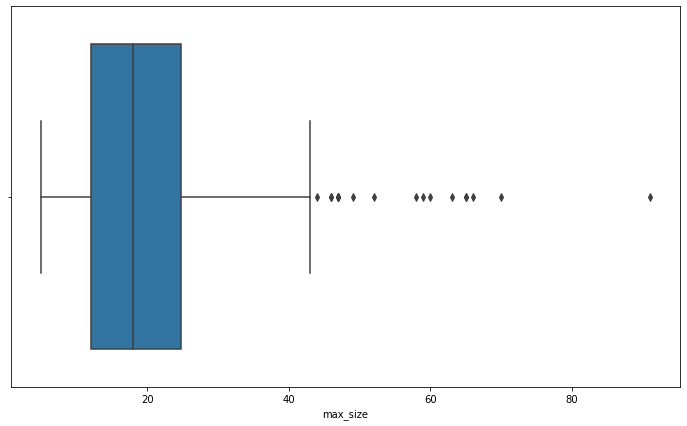

In [5]:
plt.figure(figsize=(12,7))
sns.boxplot(rimpos["max_size"])

In [25]:
len(rimpos[rimpos["max_size"] >= 35]) * 100 / len(rimpos["max_size"])

7.575757575757576

In [19]:
100 * len((rimpos[rimpos["volume"] > 5000]).index) / len(rimpos.index)

4.329004329004329

In [114]:
def analize_experts_slice_size():
    results = []
    for i in range(len(AVAILABLE_DATASETS)):
        dataset = AVAILABLE_DATASETS[i]
        for pat in tqdm(dataset.get_subjects()):
            pat = int(pat)
            rimpos_annotations_paths = dataset.get(return_type="filename", subject=f"{pat:03d}", **CONTRASTS["EXPERTS_ANNOTATIONS"])
            if len(rimpos_annotations_paths) == 0:
                print(f"Patient {pat} omitted.")
                continue
            image = nib.load(rimpos_annotations_paths[0]).get_fdata().astype(int)
            
            objects = ndimage.find_objects(image)
            if objects is None or len(objects) == 0:
                print(f"ERROR ON PATIENT {pat}")
                continue
            for (sl_x, sl_y, sl_z) in [obj for obj in objects if obj is not None]:
                results.append((pat, sl_x.start, sl_y.start, sl_z.start, sl_x.stop, sl_y.stop, sl_z.stop))
    df = pd.DataFrame(data=results, columns=["patient", "x_start", "y_start", "z_start", "x_end", "y_end", "z_end"])
    df["x_size"] = df["x_end"] - df["x_start"]
    df["y_size"] = df["y_end"] - df["y_start"]
    df["z_size"] = df["z_end"] - df["z_start"]
    return df

            

In [115]:
df_rim_ann = analize_experts_slice_size()
df_rim_ann

  0%|          | 0/69 [00:00<?, ?it/s]

Patient 56 omitted.


  4%|▍         | 3/69 [00:01<00:22,  2.87it/s]

Patient 59 omitted.


  7%|▋         | 5/69 [00:01<00:20,  3.05it/s]

Patient 61 omitted.
Patient 62 omitted.
Patient 63 omitted.


 17%|█▋        | 12/69 [00:03<00:24,  2.31it/s]

Patient 68 omitted.


 22%|██▏       | 15/69 [00:04<00:23,  2.35it/s]

Patient 71 omitted.


 25%|██▍       | 17/69 [00:05<00:19,  2.64it/s]

Patient 73 omitted.


 29%|██▉       | 20/69 [00:06<00:19,  2.52it/s]

Patient 76 omitted.


 38%|███▊      | 26/69 [00:09<00:20,  2.08it/s]

Patient 82 omitted.


 52%|█████▏    | 36/69 [00:14<00:17,  1.89it/s]

Patient 98 omitted.
Patient 99 omitted.
Patient 100 omitted.


 59%|█████▉    | 41/69 [00:15<00:12,  2.25it/s]

Patient 103 omitted.
Patient 104 omitted.
Patient 105 omitted.
Patient 106 omitted.
Patient 107 omitted.


 70%|██████▉   | 48/69 [00:16<00:08,  2.53it/s]

Patient 110 omitted.


 81%|████████  | 56/69 [00:19<00:06,  2.00it/s]

Patient 120 omitted.
Patient 121 omitted.


 91%|█████████▏| 63/69 [00:22<00:02,  2.03it/s]

Patient 127 omitted.


  2%|▏         | 1/55 [00:00<00:35,  1.53it/s]

Patient 2 omitted.
Patient 3 omitted.
Patient 4 omitted.


  9%|▉         | 5/55 [00:01<00:25,  1.98it/s]

Patient 6 omitted.
Patient 7 omitted.


 15%|█▍        | 8/55 [00:01<00:19,  2.44it/s]

Patient 9 omitted.


 18%|█▊        | 10/55 [00:02<00:17,  2.55it/s]

Patient 11 omitted.
Patient 12 omitted.


 25%|██▌       | 14/55 [00:03<00:17,  2.33it/s]

Patient 15 omitted.
Patient 16 omitted.
Patient 17 omitted.


 33%|███▎      | 18/55 [00:04<00:12,  2.87it/s]

Patient 19 omitted.


 36%|███▋      | 20/55 [00:05<00:12,  2.87it/s]

Patient 21 omitted.


 40%|████      | 22/55 [00:05<00:11,  2.98it/s]

Patient 23 omitted.
Patient 24 omitted.
Patient 25 omitted.
Patient 26 omitted.


 49%|████▉     | 27/55 [00:06<00:07,  3.64it/s]

Patient 28 omitted.


 53%|█████▎    | 29/55 [00:07<00:07,  3.38it/s]

Patient 30 omitted.


 58%|█████▊    | 32/55 [00:08<00:09,  2.45it/s]

Patient 33 omitted.


 62%|██████▏   | 34/55 [00:08<00:07,  2.76it/s]

Patient 35 omitted.
Patient 36 omitted.


 67%|██████▋   | 37/55 [00:09<00:05,  3.18it/s]

Patient 38 omitted.


 73%|███████▎  | 40/55 [00:10<00:05,  2.55it/s]

Patient 41 omitted.


 78%|███████▊  | 43/55 [00:11<00:04,  2.63it/s]

Patient 44 omitted.


 82%|████████▏ | 45/55 [00:12<00:03,  2.81it/s]

Patient 46 omitted.


 89%|████████▉ | 49/55 [00:14<00:02,  2.06it/s]

Patient 50 omitted.


 95%|█████████▍| 52/55 [00:15<00:01,  2.20it/s]

Patient 53 omitted.


100%|██████████| 55/55 [00:16<00:00,  3.36it/s]


,patient,x_start,y_start,z_start,x_end,y_end,z_end,x_size,y_size,z_size
0,57,95,119,276,108,134,292,13,15,16
1,57,97,216,257,107,224,265,10,8,8
2,57,85,246,232,94,261,243,9,15,11
3,58,150,224,251,161,240,259,11,16,8
4,60,145,233,275,161,253,276,16,20,1
...,...,...,...,...,...,...,...,...,...,...
429,51,67,125,270,92,143,271,25,18,1
430,51,73,129,263,88,142,264,15,13,1
431,52,154,214,260,165,222,261,11,8,1
432,54,95,250,244,105,259,245,10,9,1


In [66]:
df_lesions = get_dataframe_from_metadata()
df_lesions

,dataset,patient,lesion,rim,volume,ignore,main_reason,reasons,location,size
0,0,56,2000,False,146,False,NaN,,WM,"(6, 9, 8)"
1,0,56,2001,False,252,False,NaN,,Periventricular,"(7, 8, 9)"
2,0,56,2002,False,132,False,NaN,,Periventricular,"(6, 6, 6)"
3,0,56,2003,False,206,False,NaN,,Periventricular,"(6, 9, 7)"
4,0,56,2004,False,100,False,NaN,,Periventricular,"(6, 9, 4)"
...,...,...,...,...,...,...,...,...,...,...
6986,1,55,2017,False,30,True,< 45,0,Periventricular,"(6, 4, 5)"
6987,1,55,2018,False,50,False,NaN,,WM,"(4, 5, 5)"
6988,1,55,2019,False,65,False,NaN,,Periventricular,"(8, 6, 6)"
6989,1,55,2020,False,38,True,< 45,0,WM,"(3, 6, 5)"


In [80]:
# Check that the number of rim+ lesions in the GT is the same than in the experts annotations
for pat in df_lesions[df_lesions["rim"]]["patient"].unique():
    our_lesions = len(df_lesions[(df_lesions["rim"]) & (df_lesions["patient"] == pat)].index)
    gt_lesions = len(df_rim_ann[(df_rim_ann["patient"] == pat)].index)
    if our_lesions != gt_lesions:
        print(f"{pat} - {our_lesions} VS {gt_lesions}")

74 - 6 VS 9
85 - 32 VS 1


In [116]:
df_rim_ann["max_dimension"] = df_rim_ann.apply(lambda x: max(x["x_size"], x["y_size"], x["z_size"]), axis=1)
df_rim_ann = df_rim_ann.sort_values("max_dimension", ascending=False)
df_rim_ann

,patient,x_start,y_start,z_start,x_end,y_end,z_end,x_size,y_size,z_size,max_dimension
296,13,65,266,215,90,313,216,25,47,1,47
420,51,154,152,273,177,186,274,23,34,1,34
323,39,155,279,208,181,311,214,26,32,6,32
193,109,75,219,260,107,250,261,32,31,1,32
327,39,78,276,217,104,307,218,26,31,1,31
...,...,...,...,...,...,...,...,...,...,...,...
134,95,110,159,279,116,165,280,6,6,1,6
86,92,90,177,275,95,183,276,5,6,1,6
226,118,95,184,283,101,189,284,6,5,1,6
176,108,159,189,283,165,194,284,6,5,1,6


In [139]:
thirdQ = np.percentile(df_rim_ann["max_dimension"], 75)
firstQ = np.percentile(df_rim_ann["max_dimension"], 25)
interrange = thirdQ - firstQ

limit = int(np.ceil(thirdQ + interrange * 1.5))

print(limit)
print(f"{100 - 100 * np.sum(df_rim_ann['max_dimension'] > limit) / len(df_rim_ann['max_dimension']):.1f}")

22
95.6


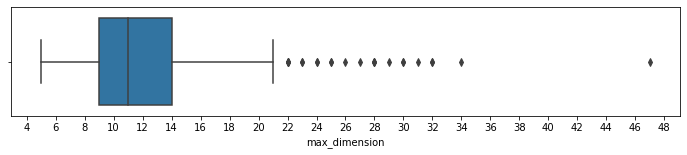

In [151]:
plt.figure(figsize=(12, 2))
plt.xticks(range(0, 51, 2))
sns.boxplot(df_rim_ann["max_dimension"])

In [113]:
def analize_experts_slice_size():
    results = []
    dataset = AVAILABLE_DATASETS[DATASET_BASEL_ID]
    pat = 95
    
    rimpos_annotations_paths = dataset.get(return_type="filename", subject=f"{pat:03d}", **CONTRASTS["EXPERTS_ANNOTATIONS"])
    if len(rimpos_annotations_paths) == 0:
        print(f"Patient {pat} omitted.")
        return 0
    image = nib.load(rimpos_annotations_paths[0]).get_fdata().astype(int)

    objects = ndimage.find_objects(image)
    if objects is None or len(objects) == 0:
        print(f"ERROR ON PATIENT {pat}")
        return 0
    counter = 1
    for (sl_x, sl_y, sl_z) in [obj for obj in objects if obj is not None]:
        if sl_y.start == 0:
            print(np.where(image==counter))
        results.append((pat, sl_x.start, sl_y.start, sl_z.start, sl_x.stop, sl_y.stop, sl_z.stop))
        counter += 1
        
    df = pd.DataFrame(data=results, columns=["patient", "x_start", "y_start", "z_start", "x_end", "y_end", "z_end"])
    df["x_size"] = df["x_end"] - df["x_start"]
    df["y_size"] = df["y_end"] - df["y_start"]
    df["z_size"] = df["z_end"] - df["z_start"]
    
    return df

analize_experts_slice_size()

,patient,x_start,y_start,z_start,x_end,y_end,z_end,x_size,y_size,z_size
0,95,109,177,283,120,186,284,11,9,1
1,95,100,166,282,109,175,283,9,9,1
2,95,102,163,279,109,169,280,7,6,1
3,95,110,159,279,116,165,280,6,6,1
4,95,111,199,278,119,206,279,8,7,1
5,95,166,183,278,172,191,279,6,8,1
6,95,110,186,283,118,193,284,8,7,1
7,95,163,162,279,171,170,280,8,8,1
8,95,165,191,271,176,209,272,11,18,1
9,95,172,197,273,179,203,274,7,6,1


In [10]:
to_concat = []
for dataset_id in range(len(AVAILABLE_DATASETS)):
    dataset = AVAILABLE_DATASETS[dataset_id]
    for pat in dataset.get_subjects():
        paths = dataset.get(return_type="filename", subject=f"{pat}", scope=SPLIT_LESIONS_METADATA["v02"]["pipeline"], suffix=SPLIT_LESIONS_METADATA["v02"]["suffix"], acquisition=None, extension="csv")
        if len(paths) == 1:
            to_concat.append(pd.read_csv(paths[0]))
            #pd.read_csv(paths[0])[["dataset_id", "patient", "lesion", "x", "y", "z", "percentage_rims", "voxels_rims", "real"]].to_csv(paths[0], index=False)

df = pd.concat(to_concat)

In [11]:
df

,dataset_id,patient,lesion,x,y,z,percentage_rims,voxels_rims,real
0,0,56,2001,79,167,197,[],[],True
1,0,56,2002,89,252,225,[],[],True
2,0,56,2003,104,276,216,[],[],True
3,0,56,2004,97,237,262,[],[],True
4,0,56,2005,101,132,249,[],[],True
...,...,...,...,...,...,...,...,...,...
79,0,112,1030,146,194,285,"[1.0, 1.0]","[44, 32]",False
80,0,112,1031,162,175,291,"[0.8070175438596491, 1.0]","[46, 44]",False
81,0,112,1032,161,173,307,"[0.5964912280701754, 0.8181818181818182]","[34, 36]",False
82,0,112,1033,161,196,306,"[0.8245614035087719, 0.9090909090909091]","[47, 40]",False


In [19]:
for (db, pat), grouped in df.groupby(["dataset_id", "patient"]):
    print(f"{pat} - {len(grouped[(grouped['lesion'] // 1000 == 1) & (grouped['real'])].index)}")

56 - 0
57 - 3
58 - 2
59 - 0
60 - 2
61 - 0
62 - 0
63 - 0
64 - 28
65 - 5
66 - 4
67 - 2
68 - 0
69 - 0
70 - 6
71 - 0
72 - 6
73 - 0
74 - 12
75 - 12
76 - 0
77 - 7
78 - 12
79 - 3
80 - 1
81 - 3
82 - 0
83 - 1
92 - 23
93 - 46
94 - 17
95 - 40
96 - 9
97 - 8
98 - 0
99 - 0
100 - 0
101 - 21
102 - 10
104 - 0
105 - 0
106 - 0
108 - 33
109 - 20
110 - 0
112 - 7


In [21]:
patients = df["patient"].unique()
patients

array([ 56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       104, 105, 106, 108, 109, 110, 112])

In [60]:
testing = [65, 66, 67, 68, 69, 70, 74, 93]
validation = [71, 83, 106, 108, 109, 112, 110]
training = [p for p in patients if p not in testing and p not in validation]

print(len(df[(df["real"]) & (df["lesion"] // 2000 == 1) & (df["patient"].isin(testing))].index))
print(len(df[(df["real"]) & (df["lesion"] // 1000 == 1) & (df["patient"].isin(testing))].index))
print(len(df.loc[(df["patient"].isin(testing)), "patient"].unique()))

393
75
8


In [64]:

print(len(df[(df["real"]) & (df["lesion"] // 2000 == 1) & (df["patient"].isin(training))].index))
print(len(df[(df["real"]) & (df["lesion"] // 1000 == 1) & (df["patient"].isin(training))].index))
print(len(df.loc[(df["patient"].isin(training)), "patient"].unique()))

1529
779
31


In [62]:

print(len(df[(df["real"]) & (df["lesion"] // 2000 == 1) & (df["patient"].isin(validation))].index))
print(len(df[(df["real"]) & (df["lesion"] // 1000 == 1) & (df["patient"].isin(validation))].index))
print(len(df.loc[(df["patient"].isin(validation)), "patient"].unique()))

344
61
7


In [66]:
print([f'{p:03d}' for p in training])

['056', '057', '058', '059', '060', '061', '062', '063', '064', '072', '073', '075', '076', '077', '078', '079', '080', '081', '082', '092', '094', '095', '096', '097', '098', '099', '100', '101', '102', '104', '105']
